In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, load_coco_data_struct, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
vocab_data, train_data, _  = load_coco_data_struct() # igore actual coco val set
val_data, train_data = train_data.split(0.3) # split further into train/val


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (1004, 304) float64
Word to index <class 'dict'> 1004
Index to word <class 'list'> 1004

Loaded train data.
Captions <class 'numpy.ndarray'> (400135, 17) int32
Image indices <class 'numpy.ndarray'> (400135,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded val data.
Captions <class 'numpy.ndarray'> (195954, 17) int32
Image indices <class 'numpy.ndarray'> (195954,) int32
Image features <class 'numpy.ndarray'> (40504, 4096) float32
Image urls <class 'numpy.ndarray'> (40504,) <U63

Splitting train data with ratio 0.3

Loaded train data.
Captions <class 'numpy.ndarray'> (120040, 17) int32
Image indices <class 'numpy.ndarray'> (120040,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded train data.
Captions <class 'numpy.ndarray'> (280095, 17) int32
Image indices <class 'numpy.ndarray'> (2800

In [4]:
def sample_image(coco_data, batch_size):
    captions, features, urls = coco_data.sample(batch_size)
    show_image_caption(captions, features, urls)

def show_image_by_data_idx(coco_data, data_idx):
    captions, features, urls = coco_data.get(data_idx)
    show_image_caption(captions, features, urls)

def show_image_caption(captions, features, urls):
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = vocab_data.decode_captions(caption)
        plt.title(caption_str)
        plt.show()

def show_image_by_image_idxs(coco_data, img_idxs):
    """
        data indices to find image
    """
    urls = coco_data.get_urls_by_image_index(img_idxs)
    for url in urls:
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()

In [5]:
def group_data_idx_by_image_idx(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_grouped_data_index_to_grouped_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_grouped_data_index_to_grouped_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sampled_image, sampled_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sampled_image.shape) * -1
    return np.concatenate([demo_image, sampled_image], axis=0), np.concatenate([demo_caption, sampled_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)



In [6]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)
    
def create_demo_sampled_batcher(coco_data):
    # create random pairing
    grouped_data_index_by_image_idx = group_data_idx_by_image_idx(coco_data.image_idx)
    grouped_captions_by_image_idx = map_grouped_data_index_to_grouped_captions(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)
    scrambled_grouped_captions_by_image_idx = scramble_image_caption_pairs(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)

    # merge both, and retain flag
    image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions_by_image_idx)
    image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_grouped_captions_by_image_idx)

    demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
    sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.zeros(image_idx_sampled.shape)))
    return demo_batcher, sample_batcher

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)   
    return image_idx_batch, caption_batch, demo_or_sampled_batch


In [7]:
demo_batcher, sample_batcher = create_demo_sampled_batcher(train_data)
val_demo_batcher, val_sample_batcher = create_demo_sampled_batcher(val_data)

In [8]:
def examine_validation(batch_size=100, to_examine=True):
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(val_demo_batcher, val_sample_batcher, batch_size)
    caption_batch = caption_batch[:,1:]
    loss, reward_per_token, mean_reward = run_validation(sess, discr, val_data, image_idx_batch, caption_batch, demo_or_sampled_batch)
    if to_examine:
        examine(val_data, image_idx_batch, caption_batch, reward_per_token, mean_reward)
    return loss

def assign_reward(sess, discr, coco_data, img_idxs, caption_sentences):
    captions = [c.split() for c in caption_sentences]
    image_feats_test = coco_data.get_image_features(img_idxs)
    caption_test = vocab_data.encode_captions(captions)
    loss, reward_per_token, mean_reward = run_test(sess, discr, image_feats_test, caption_test)
    examine(coco_data, img_idxs, caption_test, reward_per_token, mean_reward)
    return loss, reward_per_token, mean_reward

def run_validation(sess, discr, coco_data, img_idxs, caption_word_idx, demo_or_sampled_batch):
    image_feats = coco_data.get_image_features(img_idxs)
    discr.image_input.pre_feed(image_feats)
    discr.caption_input.pre_feed(caption_word_idx)
    discr.metadata_input.pre_feed(labels=demo_or_sampled_batch)
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
    
def run_test(sess, discr, img_feature_test, caption_test):
    discr.image_input.pre_feed(img_feature_test)
    discr.caption_input.pre_feed(caption_test)
    discr.metadata_input.pre_feed(labels=np.ones(img_feature_test.shape[0]))
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
                           
def examine(coco_data, chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img_idx, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        show_image_by_image_idxs(coco_data, [img_idx])
        decoded = vocab_data.decode_captions(cap).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(coco_data, demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(coco_data, chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 0 )[0], num_to_examine)
    examine_sample(chosen)

def random_sentence():
    word_idxs = np.random.choice(np.arange(vocab_data.START_ID + 1, vocab_data.vocab_dim), np.random.randint(8,12))
    return vocab_data.decode_captions(np.array([word_idxs]))


## Model

In [9]:
import tensorflow as tf
from discriminator import CaptionInput, ImageInput, MetadataInput, Discriminator, LstmScalarRewardStrategy
import layer_utils

In [10]:
tf.reset_default_graph()
caption_input = CaptionInput(word_embedding_init=vocab_data.embedding(),null_id=vocab_data.NULL_ID)
image_input = ImageInput(image_feature_dim=train_data.image_feature_dim)
metadata_input = MetadataInput()
reward_config = LstmScalarRewardStrategy.RewardConfig(
    reward_scalar_transformer = lambda x: tf.nn.tanh(layer_utils.affine_transform(x, 1, 'hidden_to_reward'))
)
discr = Discriminator(caption_input, image_input, metadata_input, reward_config=reward_config, hidden_dim=512)

## Training

In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [12]:
iter_num = 400
batch_size = 1000

train_losses = []
val_losses = []
for i in range(iter_num):
    
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    caption_batch = caption_batch[:,1::]
    image_feats_batch = train_data.get_image_features(image_idx_batch)
    
    discr.caption_input.pre_feed(caption_word_ids=caption_batch)
    discr.image_input.pre_feed(image_features=image_feats_batch)
    discr.metadata_input.pre_feed(demo_or_sampled_batch)
    loss, m, me = discr.train(sess)
        
    train_losses.append(loss)
    if i % 20 ==0:
        print("iter {}, loss: {}".format(i, loss))
    
    if i % 5 ==0:
        val_loss = examine_validation(batch_size, to_examine=False)
        val_losses.append(val_loss)
    else:
        val_losses.append(val_losses[-1])
        


iter 0, loss: 7.149879820644855e-05
iter 20, loss: -0.12773115932941437
iter 40, loss: -0.29515984654426575
iter 60, loss: -0.3779903054237366
iter 80, loss: -0.43373164534568787
iter 100, loss: -0.4471265375614166
iter 120, loss: -0.5070321559906006
iter 140, loss: -0.5180145502090454
iter 160, loss: -0.5354675054550171
iter 180, loss: -0.5160731077194214
iter 200, loss: -0.5386423468589783
iter 220, loss: -0.543089747428894
iter 240, loss: -0.5325020551681519
iter 260, loss: -0.5474278330802917
iter 280, loss: -0.557092547416687
iter 300, loss: -0.5491851568222046
iter 320, loss: -0.5562194585800171
iter 340, loss: -0.5669748783111572
iter 360, loss: -0.5571210980415344
iter 380, loss: -0.5696852803230286


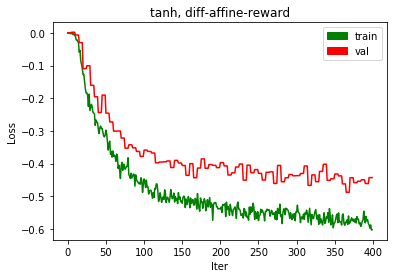

In [17]:
import matplotlib.patches as mpatches

plt.plot(np.arange(0, len(train_losses)), train_losses, 'g', val_losses, 'r')
train_loss_patch = mpatches.Patch(color='g', label='train')
val_loss_patch = mpatches.Patch(color='r', label='val')
plt.legend(handles=[train_loss_patch, val_loss_patch])
plt.ylabel('Loss')
plt.xlabel('Iter')
plt.title('tanh, diff-affine-reward')
plt.show()

DEMO RESULTS
[750 155 874 861]
Avg reward:  0.461884


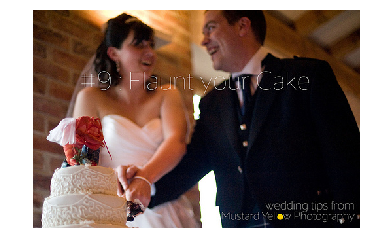

a               -0.9981943368911743
<UNK>           -0.9751248955726624
couple          0.7249865531921387
takes           0.9558302760124207
the             -0.05801301822066307
<UNK>           0.7269291281700134
slice           0.8819642066955566
of              0.2848433256149292
their           0.9994041919708252
wedding         0.9999997019767761
cake            0.999977707862854
<END>           0.9999997019767761
- - - -
Avg reward:  0.777687


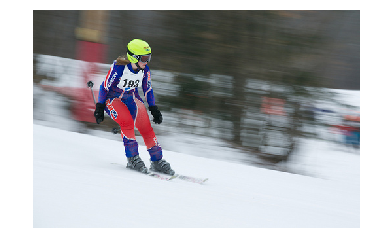

a               -0.9999950528144836
person          0.9999544620513916
on              0.9999405741691589
some            0.9998268485069275
skis            0.9995872378349304
in              0.999990701675415
the             0.9999927878379822
snow            0.999902069568634
<END>           0.9999817609786987
- - - -
Avg reward:  0.999373


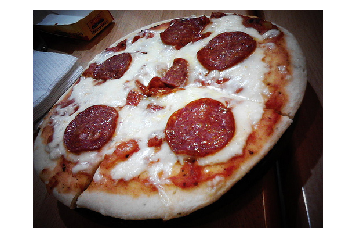

a               0.9999988079071045
pepperoni       0.9999889731407166
pizza           0.9997594952583313
with            0.9999164938926697
cheese          0.9969208240509033
cut             0.9980109333992004
into            0.9999306201934814
four            0.9999673366546631
pieces          0.9992376565933228
<END>           0.999998927116394
- - - -
Avg reward:  0.0132102


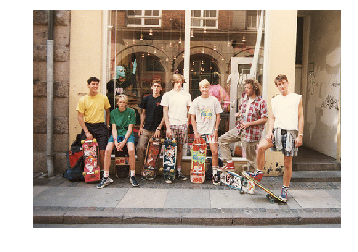

a               -0.9655728340148926
number          0.9924055933952332
of              0.9960318803787231
people          0.988728404045105
with            0.9934923648834229
skate           0.683686375617981
boards          -0.6900984644889832
on              -0.6212281584739685
a               0.5199527740478516
city            -0.7430734038352966
street          -0.9972288608551025
<END>           -0.9985730648040771
- - - -


SAMPLED RESULTS
[1024 1786 1432 1958]
Avg reward:  0.893932


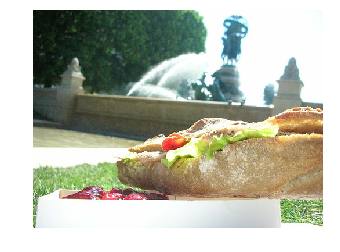

boats           1.0
and             0.9261110424995422
a               0.38743484020233154
<UNK>           0.93183833360672
<UNK>           0.9859986901283264
in              0.9143408536911011
a               0.8114700317382812
<UNK>           0.9884775280952454
<UNK>           0.9939007759094238
<END>           0.9997462630271912
- - - -
Avg reward:  -0.842925


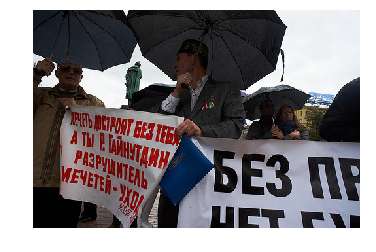

the             -0.9994609355926514
baby            0.230169877409935
is              -0.5951727628707886
playing         -0.9955793619155884
with            -0.9998828768730164
the             -0.9883773326873779
keyboard        -0.9748868346214294
of              -0.9997929930686951
the             -0.9524490237236023
computer        -0.9967513680458069
<END>           -0.9999966621398926
- - - -
Avg reward:  -0.696073


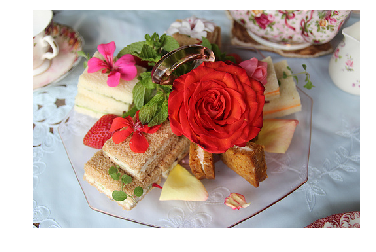

man             0.9999033212661743
in              -0.9122768044471741
<UNK>           -0.04857208579778671
surfing         -1.0
next            -0.9999998211860657
to              -0.999958336353302
a               -0.999905526638031
small           -0.9999637603759766
wave            -0.9999872446060181
<END>           -0.9999732375144958
- - - -
Avg reward:  0.891996


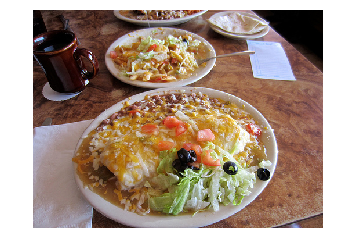

a               0.9999967813491821
orange          0.9997026324272156
on              0.8701423406600952
the             0.6168938875198364
ground          0.6259325742721558
next            0.927839994430542
to              0.760819673538208
a               0.9493861794471741
<UNK>           0.9820438623428345
of              0.9985457062721252
wood            0.992091178894043
<END>           0.9805619120597839
- - - -


In [18]:
examine_batch_results(train_data, demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

Avg reward:  0.210313


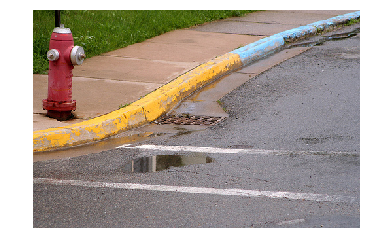

the             -0.3543757200241089
fire            0.04600191116333008
hydrant         0.9760708808898926
is              0.9916222095489502
<UNK>           0.9765687584877014
next            -0.06272774189710617
to              0.3737281858921051
the             0.9418776631355286
yellow          0.6041728854179382
striped         -0.0003804861626122147
curb            -0.9929920434951782
<END>           -0.9758085012435913
- - - -
Avg reward:  0.91931


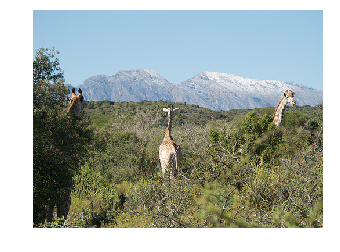

a               0.21661512553691864
group           0.9939242601394653
of              0.998701810836792
three           0.9955340027809143
giraffe         0.989482045173645
walking         0.9997208714485168
through         0.9999871253967285
a               0.9998440742492676
forest          0.9992906451225281
<END>           0.999997615814209
- - - -
Avg reward:  0.832633


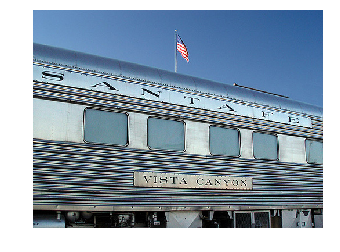

a               -0.9999551177024841
building        0.9919906258583069
with            0.9999491572380066
a               0.9999977350234985
silver          0.999999463558197
old             0.9999994039535522
style           0.9999994039535522
train           0.9999573826789856
car             0.999957799911499
on              0.9997491836547852
top             0.9999479651451111
<END>           0.9999986886978149
- - - -
Avg reward:  0.490701


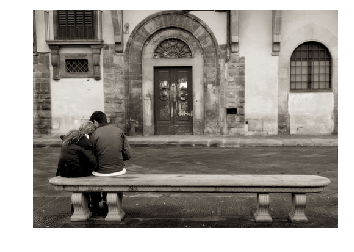

a               -0.5864445567131042
couple          -0.2060735821723938
<UNK>           0.6791337728500366
on              -0.12275555729866028
a               -0.20207569003105164
concrete        -0.03736165165901184
bench           0.9028715491294861
in              0.9528292417526245
front           0.9999887943267822
of              0.9998577237129211
a               0.9995315670967102
building        0.9997533559799194
<END>           0.999854564666748
- - - -
Avg reward:  0.833054


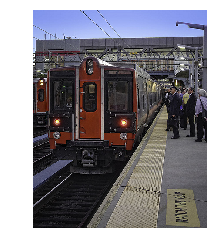

a               -0.9999766945838928
commuter        0.9970885515213013
train           0.9999765157699585
<UNK>           1.0
at              0.999999463558197
a               0.9999998807907104
station         0.9999967217445374
to              0.9999702572822571
<UNK>           0.9999964833259583
up              0.999940037727356
passengers      0.9998366236686707
<END>           0.9998239278793335
- - - -
Avg reward:  -0.999492


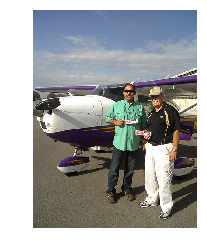

a               -0.9998912811279297
plate           -1.0
of              -0.9999894499778748
food            -1.0
with            -0.9994081258773804
<UNK>           -0.9999485611915588
potatoes        -0.9999846816062927
and             -0.9960013031959534
broccoli        -0.9998147487640381
<END>           -0.999884307384491
- - - -
Avg reward:  -0.859906


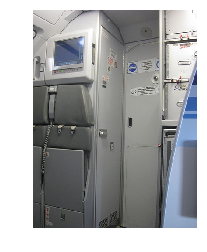

a               -0.9996140599250793
yellow          0.8185715079307556
pastry          -0.9999532699584961
is              -0.9997001886367798
wrapped         -0.9999992847442627
in              -0.9999869465827942
plastic         -0.9999999403953552
and             -0.9999772906303406
sits            -0.9999756813049316
on              -0.9999284744262695
a               -0.998676061630249
counter         -0.9995619654655457
<END>           -0.9999716877937317
- - - -
Avg reward:  -0.248365


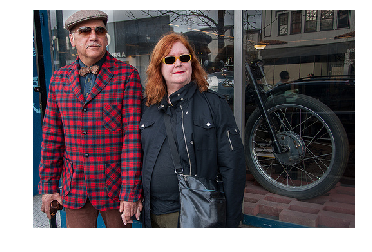

passengers      -0.999106228351593
board           -0.396944522857666
a               0.862960159778595
plane           -0.14621871709823608
on              -0.8893330097198486
an              0.32379594445228577
<UNK>           0.9740784168243408
tarmac          -0.9709475040435791
<END>           -0.9935699105262756
- - - -
Avg reward:  -0.850235


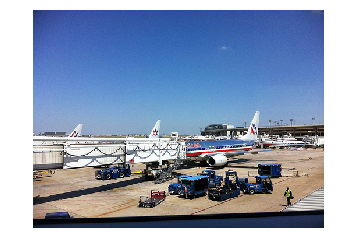

a               -0.9998504519462585
person          0.4098661541938782
holding         -0.8662494421005249
a               -0.7469521760940552
hot             -0.9999999403953552
dog             -1.0
with            -0.9999998807907104
<UNK>           -0.9999857544898987
<UNK>           -0.9999887943267822
and             -0.9999560117721558
lettuce         -0.9997193217277527
<END>           -0.9999806880950928
- - - -
Avg reward:  -0.78301


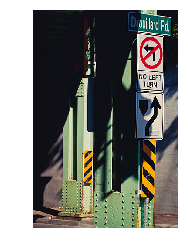

a               -0.9998406767845154
<UNK>           0.5559157729148865
like            -0.660613477230072
object          -0.9432703852653503
holding         -0.9998316168785095
up              -0.9998969435691833
a               -0.9995702505111694
hat             -0.9999858140945435
<END>           -0.9999994039535522
- - - -


-0.70270187

In [19]:
examine_validation(5, to_examine=True)


#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

#### Removing first start token makes good difference. To redo experiments. Initial results after 100 iter/ 1000 batch size per each demo/sample

Avg reward:  0.192393


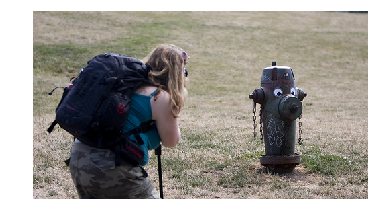

tile            0.16845455765724182
throw           0.21138937771320343
streets         0.9296530485153198
throw           0.9267537593841553
side            0.9284893274307251
reading         0.6076204180717468
wooden          -0.2020474672317505
trash           -0.06453677266836166
bag             -0.6014117002487183
military        -0.9804350137710571
- - - -
Avg reward:  -0.96358


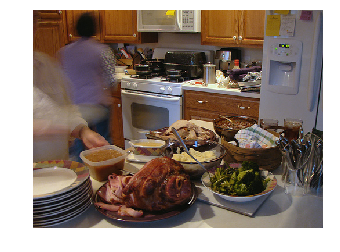

jumps           -0.6723915338516235
boat            -0.9999998807907104
fruits          -0.9998537302017212
assorted        -0.9999925494194031
three           -0.9999993443489075
vegetable       -0.9999982118606567
blurry          -0.9999993443489075
plain           -0.9999998807907104
road            -0.9999820590019226
- - - -
Avg reward:  -0.968078


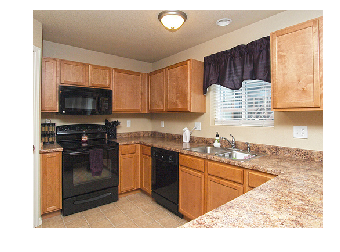

plants          -0.6846092343330383
salad           -0.9999436140060425
take            -0.9999905228614807
engine          -0.9981441497802734
child           -0.9988934397697449
on              -0.9999679327011108
pitch           -0.9999998807907104
line            -0.9992484450340271
eaten           -0.9999990463256836
soup            -0.9999879598617554
- - - -
Avg reward:  0.155906


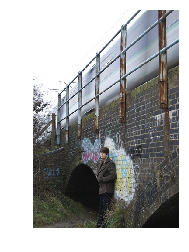

signal          -0.9999747276306152
racket          0.6934826374053955
holding         -0.8646001219749451
opened          -0.9197080135345459
stone           0.9253544807434082
contains        0.41279101371765137
highway         0.9999067783355713
antique         0.9999998211860657
- - - -
Avg reward:  0.308802


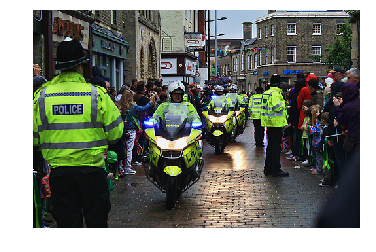

birthday        -0.9746310114860535
floating        0.994963526725769
male            -0.9996405839920044
front           -0.9578933715820312
flag            0.7287584543228149
event           0.9888883233070374
between         0.9997357130050659
fish            0.9999189972877502
net             0.9991200566291809
- - - -


In [16]:

img_idx = np.random.choice(val_data.image_idx, 5)
captions = [random_sentence()[0] for _ in range(len(img_idx))]
_ = assign_reward(sess, discr, val_data, img_idx, captions)